# Application to simulated churn data

## Import data

In [1]:
import pandas as pd

X = pd.read_csv('../datasets/churn_simulated/X.csv')
y = pd.read_csv('../datasets/churn_simulated/y.csv', header=None)
print(X.shape)
print(y.shape)

(4000, 8)
(4000, 1)


In [2]:
print(X.describe().loc[['min', '50%', 'max']])

      age  monthly_charges  tenure  n_monthly_visits  monthly_products   
min  20.0              0.0     1.0               0.0               1.0  \
50%  50.0           1496.0    35.0               5.0               5.0   
max  79.0           2998.0    69.0               9.0              17.0   

     total_charges  irrelevant_1  irrelevant_2  
min           0.00          0.00         -3.90  
50%       41061.36          0.49         -0.04  
max      279094.67          1.00          3.60  


In [3]:
print(y.value_counts())

0    3140
1     860
Name: count, dtype: int64


In [4]:
print(y.value_counts()[1] / len(y))

0.215


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3000, 8)
(1000, 8)
(3000, 1)
(1000, 1)


## Random forest

In [6]:
import lightgbm as lgb
 
lgb_data = lgb.Dataset(X_train, label=y_train, 
                       params={'feature_pre_filter': False})
params = {
    'boosting_type': 'rf',
    'objective': 'binary',
    'metric': 'binary',
    'max_depth': 3, 
    'min_child_samples': 1,
    'colsample_bytree': 0.5,
    'bagging_freq': 1,
    'bagging_fraction': 0.5,
    'n_jobs': 5,
    'random_state': 100,
    'verbose': -1}
rf = lgb.train(params, lgb_data,
               num_boost_round=1000)

In [7]:
from sklearn.metrics import classification_report

y_train_pred = rf.predict(X_train)
print(classification_report(y_train, y_train_pred > 0.5))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      2377
           1       0.86      0.76      0.81       623

    accuracy                           0.92      3000
   macro avg       0.90      0.86      0.88      3000
weighted avg       0.92      0.92      0.92      3000



In [8]:
y_test_pred = rf.predict(X_test)
print(classification_report(y_test, y_test_pred > 0.5))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       763
           1       0.86      0.77      0.82       237

    accuracy                           0.92      1000
   macro avg       0.90      0.87      0.88      1000
weighted avg       0.92      0.92      0.92      1000



In [9]:
importance = pd.DataFrame(
        rf.feature_importance('gain'),
        index=X.columns, 
        columns=['importance(gain)']) \
    .sort_values('importance(gain)', ascending=False)

importance['importance(gain)'] \
    = importance['importance(gain)'] / importance['importance(gain)'].sum()
print(importance)

                  importance(gain)
age                       0.691407
monthly_charges           0.106510
monthly_products          0.102614
total_charges             0.045406
tenure                    0.028894
n_monthly_visits          0.021468
irrelevant_2              0.001936
irrelevant_1              0.001764


## Proximity and distance matrices

In [10]:
pred_leaf = rf.predict(X_train, pred_leaf=True)
print(pred_leaf.shape)

(3000, 1000)


In [11]:
print(pred_leaf)

[[6 6 2 ... 5 5 3]
 [6 6 2 ... 5 5 6]
 [5 1 1 ... 2 6 5]
 ...
 [2 2 2 ... 1 2 3]
 [6 6 2 ... 5 5 3]
 [6 6 2 ... 5 5 6]]


In [12]:
import numpy as np
from scipy.sparse import csr_matrix, tril

def proximity_matrix_tril_from_single_array(array):
    """
    Convert an array of leaf ids from a single decision tree in random 
    forest to a proximity matrix.
    Return it as a lower triangle matrix (because the matrix is symmetric. 
    This is to reduce the memory use).
    """

    rval = np.zeros((len(array), len(array)), dtype=np.uint16)
    for leaf in np.unique(array):
        rval[array == leaf] = (array == leaf)
    return tril(rval, k=-1)

def proximity_matrix_tril_loop(pred_leaf):
    """
    Apply 'proximity_matrix_tril_from_single_array' to all trees by loop.
    Then, take the average over the trees.
    
    pred_leaf: a matrix (2d-array) with n_observations * n_trees
    """

    for i in range(pred_leaf.shape[1]):
        if (i + 1) % 100 == 0:
            print(i + 1)

        array = pred_leaf[:, i]
        proximity_matrix_tril = proximity_matrix_tril_from_single_array(array)
        if i == 0:
            sum_proximity_matrix_tril = proximity_matrix_tril
        else:
            sum_proximity_matrix_tril += proximity_matrix_tril
    
    proximity_matrix_tril = (sum_proximity_matrix_tril/pred_leaf.shape[1]) \
                                .astype(np.float16)
    return proximity_matrix_tril

def to_dense_proximity_matrix(proximity_matrix_tril):
    """
    Convert a lower triangle proximity matrix to a dense matrix.
    """

    result = proximity_matrix_tril \
            + proximity_matrix_tril.T \
            + np.eye(proximity_matrix_tril.shape[0], dtype=np.float16)
    return result

In [13]:
proximity_mtx_tril = proximity_matrix_tril_loop(pred_leaf)
# a lower triangle matrix

100
200
300
400
500
600
700
800
900
1000


In [14]:
proximity_mtx_tril.shape

(3000, 3000)

In [15]:
proximity_mtx = to_dense_proximity_matrix(proximity_mtx_tril) 
# a dense matrix

In [16]:
print(proximity_mtx.shape)

(3000, 3000)


In [17]:
print(proximity_mtx[:6, :6])

[[1.         0.83496094 0.02999878 0.09002686 0.80615234 0.15698242]
 [0.83496094 1.         0.03799438 0.11199951 0.94384766 0.27392578]
 [0.02999878 0.03799438 1.         0.30297852 0.02799988 0.01699829]
 [0.09002686 0.11199951 0.30297852 1.         0.10797119 0.06799316]
 [0.80615234 0.94384766 0.02799988 0.10797119 1.         0.23803711]
 [0.15698242 0.27392578 0.01699829 0.06799316 0.23803711 1.        ]]


In [18]:
# distance_mtx = 1 - proximity_mtx

# To enlarge the variance of the distance, it is squared, instead.
distance_mtx = np.square(1 - proximity_mtx)

print(distance_mtx[:6, :6])

[[0.         0.02723789 0.94090235 0.82805115 0.03757691 0.71067864]
 [0.02723789 0.         0.9254548  0.7885449  0.00315309 0.5271838 ]
 [0.94090235 0.9254548  0.         0.48583895 0.9447842  0.9662924 ]
 [0.82805115 0.7885449  0.48583895 0.         0.7957154  0.8686367 ]
 [0.03757691 0.00315309 0.9447842  0.7957154  0.         0.58058745]
 [0.71067864 0.5271838  0.9662924  0.8686367  0.58058745 0.        ]]


## Agglomerative clustering based on the distance matrix

In [19]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def compute_linkage(model):
    """
    Create linkage matrix for plotting the dendrogram
    """

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])

    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1 # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]).astype(float)
    return linkage_matrix

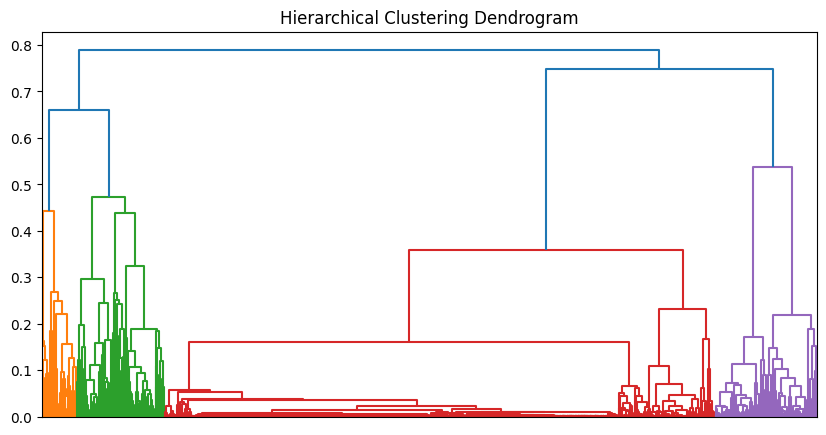

In [20]:
import matplotlib.pyplot as plt

ac = AgglomerativeClustering(
    distance_threshold=0, 
    n_clusters=None, 
    metric='precomputed', 
    compute_full_tree=True, 
    compute_distances=True, linkage='average')
ac.fit_predict(np.asarray(distance_mtx))
linkage = compute_linkage(ac)

fig, ax = plt.subplots(figsize=(10, 5)) 
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(linkage, ax=ax, labels=['']*distance_mtx.shape[0])
plt.show()

In [21]:
import matplotlib
from matplotlib import cm
from matplotlib.colors import to_hex
from matplotlib.colors import Normalize

def get_root_items(linkage):
    """
    A function used in 'get_item_average' to color dendrogram.
    """
    
    dict_items = {}
    for i, (item1, item2) in enumerate(linkage[:, :2].astype(int)):
        lst = []
        for item in [item1, item2]:
            if dict_items.get(item):
                lst += dict_items[item]
            else:
                lst.append(item)
        lst.sort()
        dict_items[i + len(linkage) + 1] = lst
    return dict_items

def get_item_average(linkage, y):
    """
    Compute the average value of 'y' under each (non-end) node.
    """
    
    dict_items = get_root_items(linkage)
    dict_y = {key: np.mean(y[value]) for key, value in dict_items.items()}
    return dict_y

def plot_colored_dendrogram(ac_model, clusters, y, cmap='jet', **kwargs):
    linkage = compute_linkage(ac_model)
    dict_items = get_root_items(linkage)

    if isinstance(y, pd.core.series.Series) \
        or isinstance(y, pd.core.frame.DataFrame):
        y = y.values
    
    linkage_new = np.hstack(
        [np.array(range(len(linkage)+1, len(linkage)*2+1)).reshape(-1, 1), 
          linkage]
    )
    n_clusters = len(np.unique(clusters))
    roots = [int(linkage_new[-1, 0])]

    for i in range(1, n_clusters):
        remove = int(linkage_new[-i, 0])
        add = [int(linkage_new[-i, 1]), int(linkage_new[-i, 2])]
        roots.remove(remove)
        roots += add # "roots" is a list of the root for each cluster
    
    dict_roots = {}
    for root in roots:
        if root < len(linkage):
            dict_roots[root] = clusters[root]
        else:
            dict_roots[root] = clusters[dict_items[root][0]]
    labels = [dict_roots.get(x) 
        for x in range(len(linkage)+1, len(linkage)*2+1)]
    
    item_average = get_item_average(linkage, y)
    
    cmap = matplotlib.colormaps[cmap]
    norm = Normalize(vmin=np.min(y), vmax=np.max(y))
    dn = dendrogram(
        linkage, 
        link_color_func= \
            lambda x: to_hex(cmap(norm(item_average[x]))), **kwargs
    )
    ii = np.argsort(np.array(dn['dcoord'])[:, 1])
    for j, (icoord, dcoord) in enumerate(zip(dn['icoord'], dn['dcoord'])):
        x_coord = 0.5 * sum(icoord[1:3])
        y_coord = dcoord[1]
        ind = np.nonzero(ii == j)[0][0]
        ax.annotate(
            labels[ind], 
            (x_coord, y_coord), 
            va='top', ha='center', fontsize=18, color='red')

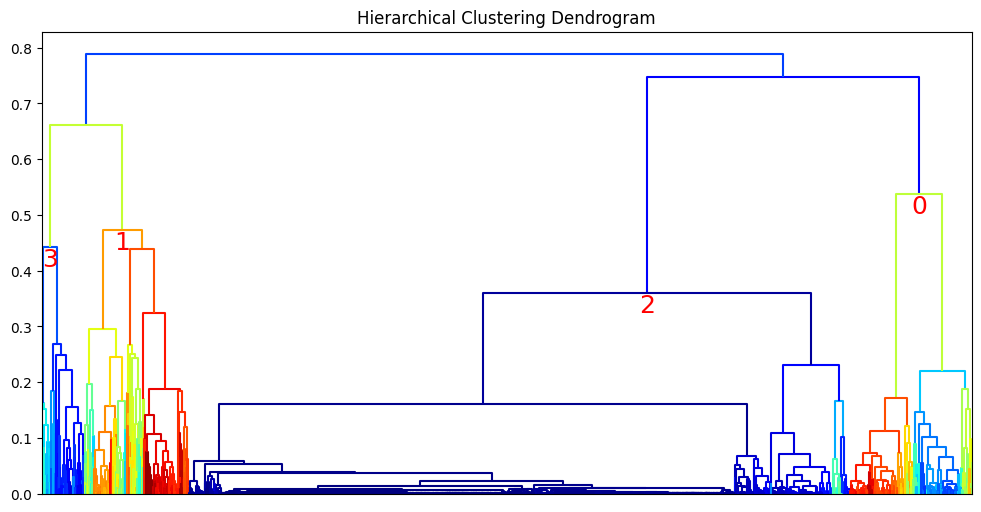

In [22]:
ac = AgglomerativeClustering(
    distance_threshold=0.6, 
    n_clusters=None, 
    metric='precomputed',
    compute_full_tree=True, 
    compute_distances=True, 
    linkage='average'
)
clusters = ac.fit_predict(np.asarray(distance_mtx))

# The dendrogram is colorred according to the expected y values, 
# averaged at each node.
fig, ax = plt.subplots(figsize=(12, 6)) 
plt.title('Hierarchical Clustering Dendrogram')
plot_colored_dendrogram(
    ac, clusters, y_train_pred, 
    labels=['']*distance_mtx.shape[0]
)
plt.show()

In [23]:
def compute_target_mean_by_cluster(X, features, clusters, y, y_hat=None):
    df_cluster = pd.DataFrame(X, columns=features).copy()
 
    if isinstance(y, pd.core.series.Series) \
        or isinstance(y, pd.core.frame.DataFrame):
        y = y.values
    df_cluster['y'] = y
    if y_hat is not None:
        df_cluster['y_hat'] = y_hat

    df_cluster['cluster_id'] = clusters
    mean_by_cluster_y = df_cluster \
        .groupby('cluster_id')['y'] \
        .agg(['count', 'mean'])
    mean_by_cluster_y.columns = ['count', 'target(y)']

    if y_hat is not None:
        mean_by_cluster_y_hat = df_cluster \
            .groupby('cluster_id')['y_hat'] \
            .agg(['mean'])
        mean_by_cluster_y_hat.columns = ['target(y_hat)']
    if y_hat is not None:
        df_rval = pd.concat(
            [mean_by_cluster_y, mean_by_cluster_y_hat], axis=1)
    else:
        df_rval = mean_by_cluster_y

    df_rval['proportion'] = df_rval['count'] / df_rval['count'].sum()
    df_rval = df_rval.sort_index()
    if y_hat is not None:
        return df_rval[
            ['count', 'proportion', 'target(y)', 'target(y_hat)']]
    return df_rval[['count', 'proportion', 'target(y)']]

per_cluster = compute_target_mean_by_cluster(
    X_train, X.columns, clusters, y_train, y_train_pred
)
print(per_cluster)

            count  proportion  target(y)  target(y_hat)
cluster_id                                             
0             392    0.130667   0.599490       0.583819
1             339    0.113000   0.787611       0.723926
2            2132    0.710667   0.050188       0.115921
3             137    0.045667   0.102190       0.265285


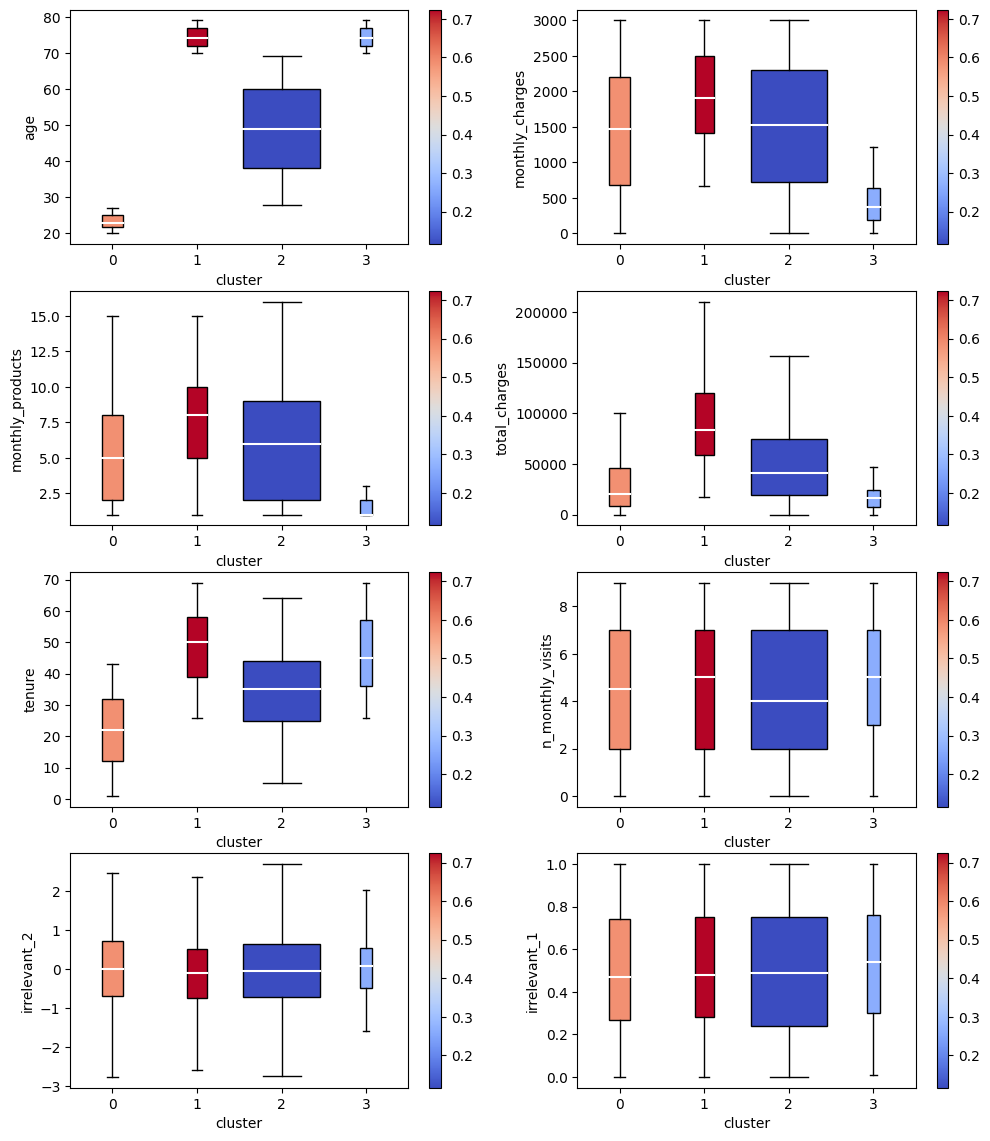

In [24]:
pd_cluster = pd.DataFrame(X_train, columns=X.columns).copy()
pd_cluster['y_hat'] = y_train_pred
pd_cluster['y'] = y_train
pd_cluster['cluster_id'] = clusters

colors = per_cluster['target(y_hat)'].values
cmap = matplotlib.colormaps['coolwarm']
norm = Normalize(vmin=np.min(colors), vmax=np.max(colors))
colors = [to_hex(x) for x in cmap(norm(colors))]

max_width = 0.9
min_width = 0.1
widths = per_cluster['proportion'].values
widths = (max_width - min_width) * widths / widths.max() + min_width

fig, ax = plt.subplots(4, 2, figsize=(12, 14))
 
for i, axi in enumerate(ax.flat):
    feature = importance.index[i]
    bins, groups = zip(*pd_cluster.groupby('cluster_id')[feature])
    bplot = axi.boxplot(
        groups, widths=widths, patch_artist=True, 
        showfliers=False, 
        medianprops=dict(color="white", linewidth=1.5)
    )
    axi.set_xticklabels(bins)
    axi.set_ylabel(feature)
    axi.set_xlabel('cluster')
 
    for box, color in zip(bplot['boxes'], colors):
        box.set_facecolor(color)
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axi)
plt.show()

## Clustering of new data

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [26]:
tree = DecisionTreeClassifier(
    criterion='entropy', max_depth=3, random_state=1
)
tree.fit(X_train, clusters)

print(tree.score(X_train, clusters))

0.9956666666666667


In [27]:
pred = tree.predict(X_train)
print(confusion_matrix(clusters, pred))

[[ 392    0    0    0]
 [   0  338    0    1]
 [   0    0 2132    0]
 [   0   12    0  125]]


In [28]:
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
import graphviz
from IPython.display import Image, display_png

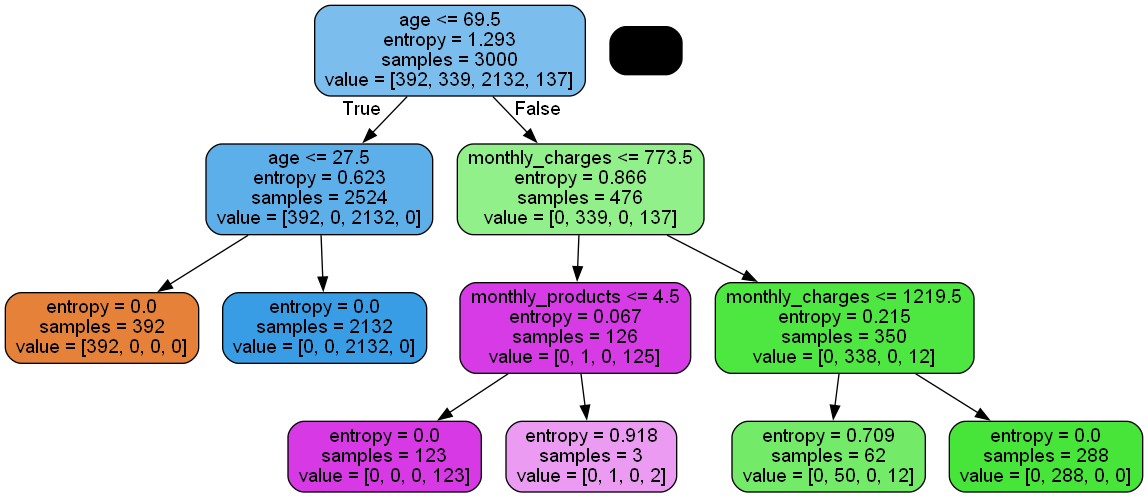

In [29]:
dot_data = export_graphviz(
    tree, filled=True, rounded=True,
    feature_names=X.columns,
    out_file=None
)
graph = graph_from_dot_data(dot_data)
graph.write_png('tree.png')
display_png(Image('tree.png'))

In [30]:
y_test_pred_cluster_id = tree.predict(X_test)
print('Summary Table of the test dataset partitioned by')
print(' the cluster predicted by the tree model')

print(compute_target_mean_by_cluster(
        X_test, X.columns, y_test_pred_cluster_id, y_test)
)

Summary Table of the test dataset partitioned by
 the cluster predicted by the tree model
            count  proportion  target(y)
cluster_id                              
0             130       0.130   0.592308
1             142       0.142   0.781690
2             673       0.673   0.049034
3              55       0.055   0.290909


In [31]:
print('Summary table of the training dataset partitioned by')
print(' the cluster predicted by the random forest model')

print(per_cluster)

Summary table of the training dataset partitioned by
 the cluster predicted by the random forest model
            count  proportion  target(y)  target(y_hat)
cluster_id                                             
0             392    0.130667   0.599490       0.583819
1             339    0.113000   0.787611       0.723926
2            2132    0.710667   0.050188       0.115921
3             137    0.045667   0.102190       0.265285


# Tuning parameters

## Cutoff point in the dendrogram

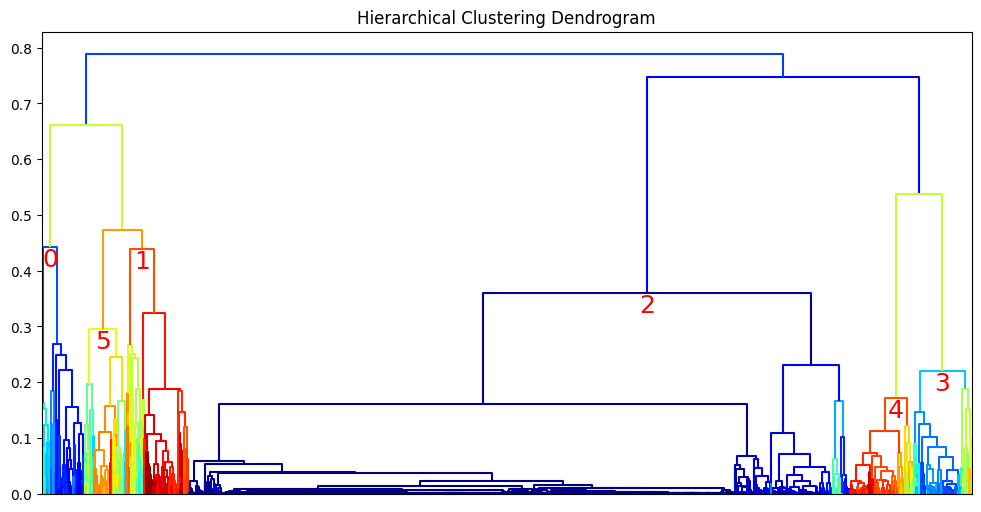

In [32]:
ac = AgglomerativeClustering(
    distance_threshold=0.45, 
    n_clusters=None, 
    metric='precomputed',
    compute_full_tree=True, 
    compute_distances=True, 
    linkage='average'
)
clusters = ac.fit_predict(np.asarray(distance_mtx))

# The dendrogram is colorred according to the expected y values, 
# averaged at each node.
fig, ax = plt.subplots(figsize=(12, 6)) 
plt.title('Hierarchical Clustering Dendrogram')
plot_colored_dendrogram(
    ac, clusters, y_train_pred, 
    labels=['']*distance_mtx.shape[0]
)
plt.show()

In [33]:
# Comparison in the average value of y and expected y (y_hat) across clusters
per_cluster = compute_target_mean_by_cluster(X_train, X.columns, clusters, y_train, y_train_pred)
print(per_cluster)

            count  proportion  target(y)  target(y_hat)
cluster_id                                             
0             137    0.045667   0.102190       0.265285
1             202    0.067333   0.905941       0.790902
2            2132    0.710667   0.050188       0.115921
3             192    0.064000   0.322917       0.366453
4             200    0.066667   0.865000       0.792490
5             137    0.045667   0.613139       0.625174


## Max depth of trees in random forest

In [34]:
params = {
    'boosting_type': 'rf',
    'objective': 'binary',
    'metric': 'binary',
    'max_depth': 5, 
    'min_child_samples': 1,
    'colsample_bytree': 0.5,
    'bagging_freq': 1,
    'bagging_fraction': 0.5,
    'n_jobs': 5,
    'random_state': 100,
    'verbose': -1}
rf = lgb.train(params, lgb_data,
               num_boost_round=1000)

In [35]:
y_train_pred = rf.predict(X_train)
print(classification_report(y_train, y_train_pred > 0.5))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2377
           1       0.93      0.85      0.89       623

    accuracy                           0.96      3000
   macro avg       0.95      0.92      0.93      3000
weighted avg       0.96      0.96      0.95      3000



In [36]:
y_test_pred = rf.predict(X_test)
print(classification_report(y_test, y_test_pred > 0.5))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       763
           1       0.90      0.83      0.86       237

    accuracy                           0.94      1000
   macro avg       0.92      0.90      0.91      1000
weighted avg       0.94      0.94      0.94      1000



In [37]:
importance = pd.DataFrame(
        rf.feature_importance('gain'),
        index=X.columns, 
        columns=['importance(gain)']) \
    .sort_values('importance(gain)', ascending=False)

importance['importance(gain)'] \
    = importance['importance(gain)'] / importance['importance(gain)'].sum()
print(importance)

                  importance(gain)
age                       0.586653
monthly_charges           0.122235
monthly_products          0.120918
total_charges             0.056834
n_monthly_visits          0.045013
tenure                    0.041168
irrelevant_2              0.014649
irrelevant_1              0.012530


In [38]:
pred_leaf = rf.predict(X_train, pred_leaf=True)
print(pred_leaf.shape)

(3000, 1000)


In [39]:
proximity_mtx_tril = proximity_matrix_tril_loop(pred_leaf)
# a lower triangle matrix

100
200
300
400
500
600
700
800
900
1000


In [40]:
proximity_mtx = to_dense_proximity_matrix(proximity_mtx_tril) 
# a dense matrix

In [41]:
# distance_mtx = 1 - proximity_mtx

# To enlarge the variance of the distance, it is squared, instead.
distance_mtx = np.square(1 - proximity_mtx)

print(distance_mtx[:6, :6])

[[0.         0.08187199 0.9623665  0.93699896 0.10291314 0.9721961 ]
 [0.08187199 0.         0.9564778  0.93894964 0.08697891 0.81004393]
 [0.9623665  0.9564778  0.         0.80455995 0.98803496 0.9702262 ]
 [0.93699896 0.93894964 0.80455995 0.         0.94090235 0.98009574]
 [0.10291314 0.08697891 0.98803496 0.94090235 0.         0.9312179 ]
 [0.9721961  0.81004393 0.9702262  0.98009574 0.9312179  0.        ]]


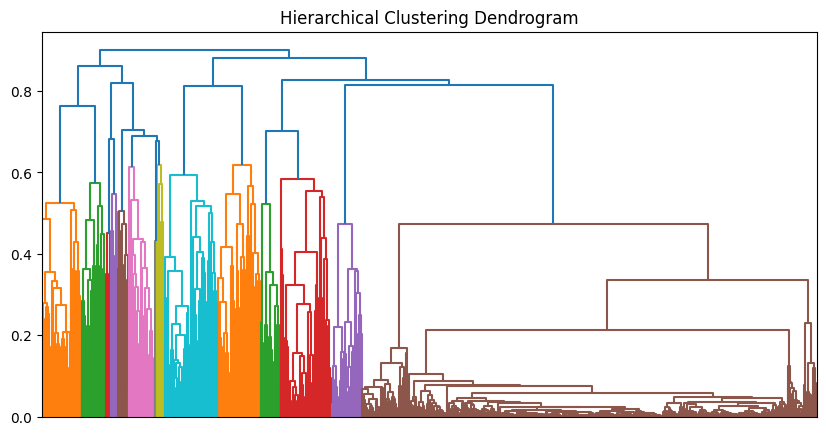

In [42]:
ac = AgglomerativeClustering(
    distance_threshold=0, 
    n_clusters=None, 
    metric='precomputed', 
    compute_full_tree=True, 
    compute_distances=True, linkage='average')
ac.fit_predict(np.asarray(distance_mtx))
linkage = compute_linkage(ac)

fig, ax = plt.subplots(figsize=(10, 5)) 
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(linkage, ax=ax, labels=['']*distance_mtx.shape[0])
plt.show()

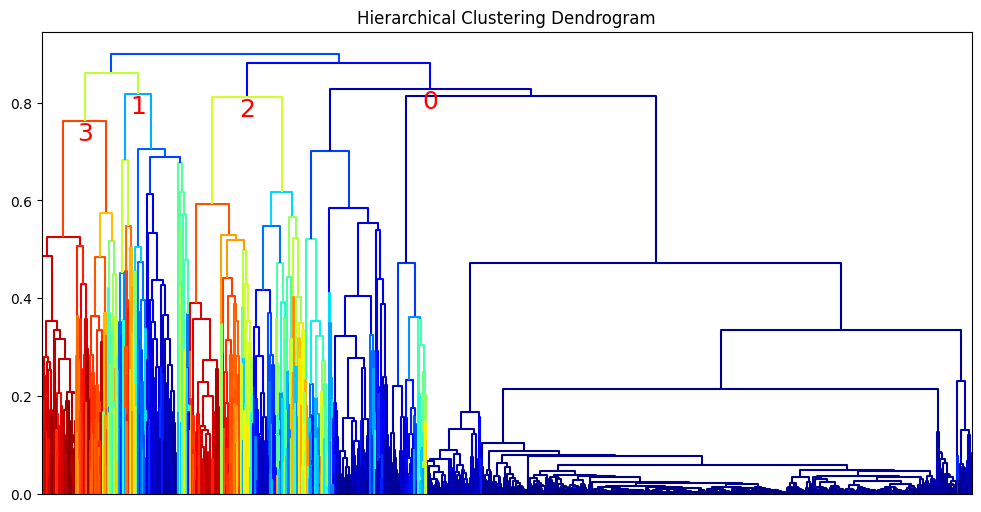

In [43]:
ac = AgglomerativeClustering(
    distance_threshold=0.84, 
    n_clusters=None, 
    metric='precomputed',
    compute_full_tree=True, 
    compute_distances=True, 
    linkage='average'
)
clusters = ac.fit_predict(np.asarray(distance_mtx))

# The dendrogram is colorred according to the expected y values, 
# averaged at each node.
fig, ax = plt.subplots(figsize=(12, 6)) 
plt.title('Hierarchical Clustering Dendrogram')
plot_colored_dendrogram(
    ac, clusters, y_train_pred, 
    labels=['']*distance_mtx.shape[0]
)
plt.show()

In [44]:
per_cluster = compute_target_mean_by_cluster(
    X_train, X.columns, clusters, y_train, y_train_pred
)
print(per_cluster)

            count  proportion  target(y)  target(y_hat)
cluster_id                                             
0            2151    0.717000   0.049744       0.121824
1             227    0.075667   0.281938       0.341270
2             373    0.124333   0.630027       0.610780
3             249    0.083000   0.871486       0.815043
